In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import jax.random as jr
import tensorflow_probability as tfp
from jax import numpy as jnp, random as jr
from sbijax import NPE
from sbijax.nn import make_maf, make_mdn
from tensorflow_probability.substrates.jax import distributions as tfd

from sbijax import plot_posterior, plot_trace, plot_rank, plot_rhat_and_ress
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import matplotlib as mpl
mpl.rcParams.update({"text.usetex": False,
                     })#mpl.rcParamsDefault)

mpl.rcParams.update(mpl.rcParamsDefault)

gpu


2025-01-19 22:55:12.228327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 22:55:12.228474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 22:55:12.378091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 22:55:22.987640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tfp.__version__

'0.24.0'

In [3]:
jnp.ones((3,))

2025-01-19 22:56:01.411123: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.0 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Array([1., 1., 1.], dtype=float32)

In [4]:
pwd

'/home/makinen/repositories/des-hybrid/vanilla-comparison'

In [5]:
cd /home/makinen/repositories/des-hybrid/wl-sbi/automate_run

/home/makinen/repositories/des-hybrid/wl-sbi/automate_run


/home/makinen/venvs/epe/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# des tfrecords loader code

In [6]:
foos = ["1_1", "3_4"]

if "_" in foos[0]:
    print('yeet')

yeet


In [20]:
np.ones((1,3,))[:, [0]].shape, np.ones((1,3,))[:, 0][:, np.newaxis].shape

((1,), (1, 1))

In [46]:
import glob
import os

import tensorflow as tf
import tensorflow_datasets as tfds


base_path = "/data103/makinen/des_sims/Gower_street_SBI_tfrecords/"
patch = "A"
use_noise_realisations =['0','1','2','3','10', '11', '12']#,'11','12','13','14','15']
cls_stats_file = np.load("/home/makinen/repositories/des-hybrid/cls_utils/cls_statistics_for_normalisation.npz")
S1_cls=cls_stats_file["S1_cls"]
S2_cls=cls_stats_file["S2_cls"]
mean_cl=cls_stats_file["mean_cl"]
std_cl=cls_stats_file["std_cl"]
cut_idx=cls_stats_file["cut_idx"]


def gaussian_noise_augmentation(x, y, cls, param_idx=None):
    x += tf.random.normal(
                        shape = [512, 512,8],
                        mean = 0,
                        stddev = 1e-3,
                        dtype = tf.float32
                        ) #Mask option?

    # add noise to cls
    cls += tf.random.normal(
                shape = [10, 2, 4, 28],
                mean = 0, 
                stddev =std_cl*1e-3,
                dtype = tf.float32
                )

    if param_idx is not None:
        y = tf.expand_dims(y[param_idx], 0)

    # data is now a dictionary
    return {"y": {"kappa": x, "cls": cls}, "theta": y}



def ret_scaled_param(data,param):
    s = 0.6
    if param == 'AIA':
        hi = 3
        lo = -3

    if param == "s8":
        hi = 1.32
        lo = 0.4

    if param == 'om':
        hi = 0.5
        lo = 0.13

    if param == "h":
        hi = 0.6
        lo = 0.8

    if param == 'w':
        hi = -0.33
        lo = -1.8
    if param == "ns":
        hi = 0.99
        lo = 0.94
    if param == 'ob':
        hi = 0.061
        lo = 0.037


    return (data[param] -lo)*s/(hi - lo) + (1 - s)*0.5

def param_proc(data, scale_params=True):
    Y = []
    for p in sel_params:
        # scale params if so desired
        if scale_params:
            if p=="S8":
                Y.append(data["s8"]*tf.math.sqrt(data["om"]/0.3)-0.25)
            else:
                Y.append(ret_scaled_param(data, p))
                
        # else just return the param
        else:
            Y.append(data[p])
            
    Y = tf.convert_to_tensor( Y , dtype = tf.float32)
    return Y

def cls_proc(data):
    Cls = []
    for c in cl_modes:

        cls = tf.io.parse_tensor(data[c], out_type=tf.float32)
        cls = tf.cast(cls, tf.float32)
        
        Cls.append(cls)
    
    return Cls #tf.convert_to_tensor(Cls, dtype=tf.float32)

def return_train_test_lists(patch):
    files = glob.glob(base_path + "{}/".format(patch) +"shear_maps_*")
    print(base_path + "{}/".format(patch) +"shear_maps_*")
    print(len(files))
    train_file_list = []
    test_file_list = []
    lfi_file_list = []
    test_file_systematic_list = []
    for file in files:
        noiserel = file.split("_rel")[0].split('noiserel')[-1]
        if noiserel in use_noise_realisations:
            if noiserel == '3':
                test_file_list.append(file)
            elif noiserel == '10':
                lfi_file_list.append(file)
            elif noiserel == '12':
                test_file_systematic_list.append(file)
            else:
                train_file_list.append(file)
    return train_file_list, test_file_list, lfi_file_list, test_file_systematic_list

def parse_serialized_file(cereal_yum, scale_params=True, filter_w=True):

    features = {
            "kappa_patch":  tf.io.FixedLenFeature([], tf.string),
            #"CLS":  tf.io.FixedLenFeature([], tf.float32, default_value=0.0),

            # load the cls values
            "1_1": tf.io.FixedLenFeature([], tf.string),
            "1_2": tf.io.FixedLenFeature([], tf.string),
            "1_3": tf.io.FixedLenFeature([], tf.string),
            "1_4": tf.io.FixedLenFeature([], tf.string),
            "2_2": tf.io.FixedLenFeature([], tf.string),
            "2_3": tf.io.FixedLenFeature([], tf.string),
            "2_4": tf.io.FixedLenFeature([], tf.string),
            "3_3": tf.io.FixedLenFeature([], tf.string),
            "3_4": tf.io.FixedLenFeature([], tf.string),
            "4_4": tf.io.FixedLenFeature([], tf.string),

            # load parameters
            "s8": tf.io.FixedLenFeature([], tf.float32),
            "om": tf.io.FixedLenFeature([], tf.float32),
            "AIA": tf.io.FixedLenFeature([], tf.float32),
            "w": tf.io.FixedLenFeature([], tf.float32)
    }

    data = tf.io.parse_single_example(cereal_yum, features)

    # filter out w < -1
    # dummyY = param_proc(data, scale_params=False)
    # if filter_w:
    #     if dummyY[2] < -1:
    #         pass
            
    #     else:
    #         # process params and Cls
    #         Y = param_proc(data, scale_params=scale_params)
    #         CLS_DS = cls_proc(data)
        
    #         X_DS = tf.io.parse_tensor(data["kappa_patch"], out_type=tf.float32)
    #         X_DS = tf.cast(X_DS, tf.float32)
    #         X_DS = tf.reshape(X_DS, shape=(8,512,512))
    #         X_DS = tf.transpose(X_DS, perm = [1,2,0])
        
    #         return X_DS,Y,CLS_DS

    # else:
    # proceed as usual to get everything
    Y = param_proc(data, scale_params=scale_params)
    CLS_DS = cls_proc(data)

    X_DS = tf.io.parse_tensor(data["kappa_patch"], out_type=tf.float32)
    X_DS = tf.cast(X_DS, tf.float32)
    X_DS = tf.reshape(X_DS, shape=(8,512,512))
    X_DS = tf.transpose(X_DS, perm = [1,2,0])
    
    return X_DS,Y,CLS_DS





def get_single_param(data, param_idx=0):
    return {"y": {"kappa": data["y"]["kappa"], "cls": data["y"]["cls"]}, "theta": data["theta"][:, param_idx][:, np.newaxis]}
    

#train_dataset_single = train_dataset.map(lambda d: get_single_param(d),num_parallel_calls=tf.data.AUTOTUNE)



with tf.device("CPU"):
    sel_params = ["om","s8","w"]
    cl_modes = ["1_1","1_2","1_3","1_4","2_2","2_3","2_4","3_3","3_4", "4_4"]
    BATCH_SIZE = 64
    EPOCHS = 1000 # max epochs
    n_readers=1
    try:
        del train_dataset
        del test_dataset
        gc.collect()
    except:
        pass        

    SHUFFLE_BUFFER_SIZE = 100
    train_files, test_files, lfi_files, test_sys_files = return_train_test_lists('{}'.format(patch))
    num_train_files = len(train_files)
    num_test_files = len(test_files)
    num_lfi_files = len(lfi_files)
    num_sys_files = len(test_sys_files)

    print("train files: ", num_train_files, "test files: ", num_test_files, "lfi files: ", num_lfi_files, "test sys files: ", num_sys_files,)


    def get_tfdataset(files, 
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS,
                          scale_params=True, 
                          param_idx=None,
                          to_numpy=True,
                          shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
                          drop_remainder=True):
        
        num_files = len(files)
        print("num files: ", num_files)
        tfdataset = tf.data.Dataset.from_tensor_slices(files)

        if param_idx is not None:
            print("retrieving parameter %d"%(param_idx))
        
        tfdataset = tfdataset.interleave(
            tf.data.TFRecordDataset,
            cycle_length=n_readers,
            block_length=1,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True,
        )

        tfdataset = tfdataset.map(
            lambda serialized_example: parse_serialized_file(
                serialized_example,
                scale_params=scale_params    
            ),
            num_parallel_calls=tf.data.AUTOTUNE,
        )

        tfdataset = tfdataset.shuffle(shuffle_buffer_size)
        tfdataset = tfdataset.map(lambda maps,vals,cls: \
                                  gaussian_noise_augmentation(maps,vals,cls,param_idx=param_idx),\
                                  num_parallel_calls=tf.data.AUTOTUNE)
        tfdataset = tfdataset.batch(batch_size, drop_remainder=drop_remainder).prefetch(tf.data.AUTOTUNE) 
        tfdataset = tfdataset.repeat(epochs)
        

        if to_numpy:
            tfdataset = tfdataset.as_numpy_iterator()
            tfdataset.num_batch_per_epoch = num_files // batch_size
            tfdataset.num_samples = (num_files // batch_size) * batch_size


        return tfdataset
        

    # train, test validation datasets
    train_dataset = get_tfdataset(train_files, BATCH_SIZE, scale_params=True, to_numpy=True)
    
    test_dataset = get_tfdataset(test_files, BATCH_SIZE, scale_params=True, to_numpy=True)

    lfi_dataset = get_tfdataset(lfi_files, BATCH_SIZE, scale_params=False, to_numpy=True, epochs=5, drop_remainder=False)
    sys_dataset = get_tfdataset(test_sys_files, BATCH_SIZE, scale_params=False, to_numpy=True, epochs=5, drop_remainder=False)

    

/data103/makinen/des_sims/Gower_street_SBI_tfrecords/A/shear_maps_*
30880
train files:  12352 test files:  3088 lfi files:  3088 test sys files:  3088
num files:  12352
num files:  3088
num files:  3088
num files:  3088


In [47]:
train_dataset.num_samples, train_dataset.num_batch_per_epoch, 

(12352, 193)

In [48]:
foob = get_tfdataset(train_files, BATCH_SIZE, scale_params=True, to_numpy=False, param_idx=0)

num files:  12352
retrieving parameter 0


In [49]:
next(iter(foob))['theta'].shape

TensorShape([64, 1])

## adapt the mdn code from `sbijax` into flax

In [50]:
from functools import partial

import jax
import numpy as np
import optax
from absl import logging
from jax import numpy as jnp
from jax import random as jr
from jax import scipy as jsp
from jax._src.flatten_util import ravel_pytree
from tqdm import tqdm
import sys,os

from sbijax._src._ne_base import NE
from sbijax._src.util.data import as_inference_data
from sbijax._src.util.early_stopping import EarlyStopping
#from sbijax._src.util.dataloader import as_batch_iterators

from collections.abc import Iterable
from typing import Callable, Sequence

import haiku as hk
import haiku.experimental.flax as hkflax
import flax.linen as nn
import jax
from jax import numpy as jnp
from tensorflow_probability.substrates.jax import distributions as tfd


from pathlib import Path
#Path("/my/directory").mkdir(parents=True, exist_ok=True)


# custom dataloader class to support additive noise (or simulator)


# ruff: noqa: PLR0913, E501
class myNPE(NE):
    """Neural posterior estimation.

    Implements the method introduced in :cite:t:`greenberg2019automatic`.
    In the literature, the method is usually referred to as APT or NPE-C, but
    here we refer to it simply as NPE.

    Args:
        model_fns: a tuple of calalbles. The first element needs to be a
            function that constructs a tfd.JointDistributionNamed, the second
            element is a simulator function.
        density_estimator: a (neural) conditional density estimator
            to model the posterior distribution
        num_atoms: number of atomic atoms

    Examples:
        >>> from sbijax import NPE
        >>> from sbijax.nn import make_maf
        >>> from tensorflow_probability.substrates.jax import distributions as tfd
        ...
        >>> prior = lambda: tfd.JointDistributionNamed(
        ...     dict(theta=tfd.Normal(0.0, 1.0))
        ... )
        >>> s = lambda seed, theta: tfd.Normal(theta["theta"], 1.0).sample(seed=seed)
        >>> fns = prior, s
        >>> neural_network = make_maf(1)
        >>> model = NPE(fns, neural_network)

    References:
        Greenberg, David, et al. "Automatic posterior transformation for likelihood-free inference." International Conference on Machine Learning, 2019.
    """

    def __init__(self, model_fns, density_estimator, num_atoms=10):
        """Construct an SNP object.

        Args:
            model_fns: a tuple of tuples. The first element is a tuple that
                    consists of functions to sample and evaluate the
                    log-probability of a data point. The second element is a
                    simulator function.
            density_estimator: a (neural) conditional density estimator
                to model the posterior distribution
            num_atoms: number of atomic atoms
        """
        super().__init__(model_fns, density_estimator)
        self.num_atoms = num_atoms
        self.n_round = 0

    # ruff: noqa: D417
    def fit(
        self,
        rng_key,
        data,
        *,
        train_dataset=None,
        val_dataset=None,
        noise_simulator=None,
        optimizer=optax.adam(0.0003),
        n_iter=1000,
        batch_size=128,
        percentage_data_as_validation_set=0.1,
        n_early_stopping_patience=10,
        params = None,
        outdir = "./net-logs/",
        theta_idx = None,
        **kwargs,
    ):
        """Fit an SNP model.

        Args:
            rng_key: a jax random key
            data: data set obtained from calling
                `simulate_data_and_possibly_append`
            noise_simulator: noise function with signature `data_noise = fn(key, data)`
            optimizer: an optax optimizer object
            n_iter: maximal number of training iterations per round
            batch_size:  batch size used for training the model
            percentage_data_as_validation_set: percentage of the simulated
                data that is used for validation and early stopping
            n_early_stopping_patience: number of iterations of no improvement
                of training the flow before stopping optimisation


        Returns:
            a tuple of parameters and a tuple of the training information
        """
        itr_key, rng_key = jr.split(rng_key)

        Path(outdir).mkdir(parents=True, exist_ok=True)
        
        if train_dataset is None:
            train_iter, val_iter = self.as_iterators(
                itr_key, data, batch_size, percentage_data_as_validation_set,
                noise_simulator
            )
        else:
            train_iter = train_dataset
            val_iter = val_dataset

        if params is None:
            params, losses = self._fit_model_single_round(
                seed=rng_key,
                train_iter=train_iter,
                val_iter=val_iter,
                optimizer=optimizer,
                n_iter=n_iter,
                n_early_stopping_patience=n_early_stopping_patience,
                n_atoms=self.num_atoms,
            )
        else:
            params, losses = self._fit_model_single_round(
                seed=rng_key,
                train_iter=train_iter,
                val_iter=val_iter,
                optimizer=optimizer,
                n_iter=n_iter,
                n_early_stopping_patience=n_early_stopping_patience,
                n_atoms=self.num_atoms,
                params=params,
                outdir=outdir,
                theta_idx=theta_idx
            )

        return params, losses

    # pylint: disable=undefined-loop-variable
    def _fit_model_single_round(
        self,
        seed,
        train_iter,
        val_iter,
        optimizer,
        n_iter,
        n_early_stopping_patience,
        n_atoms,
        params=None,
        outdir="./net-logs/",
        theta_idx=None
    ):
        init_key, seed = jr.split(seed)
        if params is None:
            params = self._init_params(init_key, **next(iter(train_iter)))
        else:
            params = params
        # intialise opt state
        state = optimizer.init(params)

        n_round = self.n_round
        if n_round == 0:

            def loss_fn(params, rng, **batch):
                # upack tuple
                lp = self.model.apply(
                    params,
                    None,
                    method="log_prob",
                    y=jnp.array(batch["theta"]),
                    x=batch["y"],
                )
                return -jnp.mean(lp)

        else:

            def loss_fn(params, rng, **batch):
                lp = self._proposal_posterior_log_prob(
                    params,
                    rng,
                    n_atoms,
                    theta=jnp.array(batch["theta"]),
                    y=jnp.array(batch["y"]),
                )
                return -jnp.mean(lp)

        @jax.jit
        def step(params, rng, state, **batch):
            loss, grads = jax.value_and_grad(loss_fn)(params, rng, **batch)
            updates, new_state = optimizer.update(grads, state, params)
            new_params = optax.apply_updates(params, updates)
            return loss, new_params, new_state

        losses = np.zeros([n_iter, 2])
        early_stop = EarlyStopping(1e-3, n_early_stopping_patience)
        best_params, best_loss = None, np.inf
        logging.info("training model")

        pbar = tqdm(range(n_iter), leave=True, position=0) # progress bar
        for i in pbar:
            train_loss = 0.0
            rng_key = jr.fold_in(seed, i)
            for b in range(train_iter.num_batch_per_epoch):

                batch = next(iter(train_iter))
                train_key, rng_key = jr.split(rng_key)
                batch_loss, params, state = step(
                    params, train_key, state, **batch
                )
                #print("batch_loss", batch_loss)
                train_loss += batch_loss * (
                    jax.tree.leaves(batch["y"])[0].shape[0] / train_iter.num_samples
                )
                #print("train_loss", train_loss)
            
            val_key, rng_key = jr.split(rng_key)
            validation_loss = self._validation_loss(
                val_key, params, val_iter, n_atoms
            )
            #print("validation_loss", validation_loss)
            
            losses[i] = jnp.array([train_loss, validation_loss])
            pbar.set_description('epoch %d loss: %.5f  val loss: %.5f'%(i, train_loss, validation_loss))
            
            _, early_stop = early_stop.update(validation_loss)
            if early_stop.should_stop:
                logging.info("early stopping criterion found")
                break
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_params = params.copy()
                save_obj(best_params, outdir + "best_params")

        self.n_round += 1
        losses = jnp.vstack(losses)[: (i + 1), :]
        return best_params, losses

    def _init_params(self, rng_key, **init_data):
        params = self.model.init(
            rng_key, method="log_prob", y=jnp.array(init_data["theta"]), x=init_data["y"]
        )
        return params

    def _proposal_posterior_log_prob(self, params, rng, n_atoms, theta, y):
        n = theta.shape[0]
        n_atoms = np.maximum(2, np.minimum(n_atoms, n))
        repeated_y = jnp.repeat(y, n_atoms, axis=0)
        probs = jnp.ones((n, n)) * (1 - jnp.eye(n)) / (n - 1)

        choice = partial(
            jr.choice, a=jnp.arange(n), replace=False, shape=(n_atoms - 1,)
        )
        sample_keys = jr.split(rng, probs.shape[0])
        choices = jax.vmap(lambda key, prob: choice(key, p=prob))(
            sample_keys, probs
        )
        contrasting_theta = theta[choices]

        atomic_theta = jnp.concatenate(
            (theta[:, None, :], contrasting_theta), axis=1
        )
        atomic_theta = atomic_theta.reshape(n * n_atoms, -1)

        log_prob_posterior = self.model.apply(
            params, None, method="log_prob", y=atomic_theta, x=repeated_y
        )
        log_prob_posterior = log_prob_posterior.reshape(n, n_atoms)
        log_prob_prior = self.prior_log_density_fn(atomic_theta)
        log_prob_prior = log_prob_prior.reshape(n, n_atoms)

        unnormalized_log_prob = log_prob_posterior - log_prob_prior
        log_prob_proposal_posterior = unnormalized_log_prob[
            :, 0
        ] - jsp.special.logsumexp(unnormalized_log_prob, axis=-1)

        return log_prob_proposal_posterior

    def _validation_loss(self, rng_key, params, val_iter, n_atoms):
        if self.n_round == 0:

            def loss_fn(rng, **batch):
                lp = self.model.apply(
                    params,
                    None,
                    method="log_prob",
                    y=jnp.array(batch["theta"]),
                    x=batch["y"],
                )
                return -jnp.mean(lp)

        else:

            def loss_fn(rng, **batch):
                lp = self._proposal_posterior_log_prob(
                    params, rng, n_atoms, jnp.array(batch["theta"]), batch["y"]
                )
                return -jnp.mean(lp)

        def body_fn(batch, rng_key):
            loss = jax.jit(loss_fn)(rng_key, **batch)
            return loss * (jax.tree.leaves(batch["y"])[0].shape[0] / val_iter.num_samples)

        loss = 0.0
        for b in range(val_iter.num_batch_per_epoch):
            batch = next(iter(val_iter))
            val_key, rng_key = jr.split(rng_key)
            loss += body_fn(batch, val_key)
        return loss

    @staticmethod
    def as_iterators(
        rng_key, data, batch_size, percentage_data_as_validation_set,
        noise_simulator
    ):
        """Convert the data set to an iterable for training.

        Args:
            rng_key: a jax random key
            data: a tuple with 'y' and 'theta' elements
            batch_size: the size of each batch
            percentage_data_as_validation_set: fraction

        Returns:
            two batch iterators
        """
        print("hooray")
        return as_batch_iterators(
            rng_key,
            data,
            batch_size,
            1.0 - percentage_data_as_validation_set,
            True,
            noise_simulator
        )

    def sample_posterior(
        self, rng_key, params, observable, *, n_samples=4_000, **kwargs
    ):
        r"""Sample from the approximate posterior.

        Args:
            rng_key: a jax random key
            params: a pytree of neural network parameters
            observable: observation to condition on
            n_samples: number of samples to draw

        Returns:
            returns an array of samples from the posterior distribution of
            dimension (n_samples \times p)
        """
        observable = jnp.atleast_2d(observable)

        thetas = None
        n_curr = n_samples
        n_total_simulations_round = 0
        _, unravel_fn = ravel_pytree(self.prior_sampler_fn(seed=jr.PRNGKey(1)))
        while n_curr > 0:
            n_sim = jnp.minimum(200, jnp.maximum(200, n_curr))
            n_total_simulations_round += n_sim
            sample_key, rng_key = jr.split(rng_key)
            proposal = self.model.apply(
                params,
                sample_key,
                method="sample",
                sample_shape=(n_sim,),
                x=jnp.tile(observable, [n_sim, 1]),
            )
            proposal_probs = self.prior_log_density_fn(
                jax.vmap(unravel_fn)(proposal)
            )
            proposal_accepted = proposal[jnp.isfinite(proposal_probs)]
            if thetas is None:
                thetas = proposal_accepted
            else:
                thetas = jnp.vstack([thetas, proposal_accepted])
            n_curr -= proposal_accepted.shape[0]
        self.n_total_simulations += n_total_simulations_round

        ess = float(thetas.shape[0] / n_total_simulations_round)
        thetas = jax.tree_map(
            lambda x: x.reshape(1, *x.shape),
            jax.vmap(unravel_fn)(thetas[:n_samples]),
        )
        inference_data = as_inference_data(thetas, jnp.squeeze(observable))
        return inference_data, ess



#TODO: SHOULD WE ADD A LAYERNORM TO THE INITIAL INPUTS OF THE FIRST NETWORK LAYER ??


# pylint: disable=too-many-arguments
def my_make_mdn(
    n_dimension: int,
    n_components: int,
    hidden_sizes: Iterable[int] = (64, 64),
    activation: Callable = jax.nn.swish,
    embedding_net: nn.Module = None,
):
    """Create an affine masked autoregressive flow.

    The MAFs use `n_layers` layers and are parameterized using MADE networks
    with `hidden_sizes` neurons per layer.

    Args:
        n_dimension: dimensionality of theta
        n_components: number of mixture components
        hidden_sizes: sizes of hidden layers for each normalizing flow. E.g.,
            when the hidden sizes are a tuple (64, 64), then each maf layer
            uses a MADE with two layers of size 64 each
        activation: a jax activation function

    Returns:
        a normalizing flow model
    """

    @hk.transform
    def mdn(method, **kwargs):

        #n = kwargs["x"].shape[0]
        #x = jnp.array(kwargs["x"])
        n = jax.tree.leaves(kwargs["x"])[0].shape[0] # all elements of data dict should be batched
        x = kwargs["x"]

        #print("x mdn input", x.shape)

        # optional embedding network
        if embedding_net is not None:
          mod = hkflax.lift(embedding_net, name='flax_embedding_net')
          # add in a vmap here
          x = jax.vmap(mod)(x)

        xembed = x
        # rest of network
        hidden = hk.nets.MLP(
            hidden_sizes, activation=activation, activate_final=True
        )(x)
        #print("hidden", hidden.shape)
        logits = hk.Linear(n_components)(hidden)
        mu_sigma = hk.Linear(n_components * n_dimension * 2)(hidden)
        mu, sigma = jnp.split(mu_sigma, 2, axis=-1)

        mixture = tfd.MixtureSameFamily(
            tfd.Categorical(logits=logits),
            tfd.MultivariateNormalDiag(
                mu.reshape(n, n_components, n_dimension),
                jnp.exp(sigma.reshape(n, n_components, n_dimension)),
            ),
        )
        if method == "sample":
            return mixture.sample(seed=hk.next_rng_key())
        elif method == "embedding":
            # could also return logits, mu_sigma
            return xembed
        else:
            return mixture.log_prob(kwargs["y"])

    return mdn



In [51]:
pwd

'/home/makinen/repositories/des-hybrid/wl-sbi/automate_run'

In [52]:
#@title config code
import sys,os
import yaml
import jax_cosmo as jc

from network.cls_utils import *
# from network.moped_auto import *
# from network.moped import *
from network.net_utils import *

import sys,os
import yaml

from network.cls_utils import *
# from network.moped_auto import *
# from network.moped import *
from network.net_utils import *

import numpy as np

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


# -----
# folder to load config file
CONFIG_PATH = "./config"

config_name = "config_N128.yaml"
noiseamp = 0.125

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

config = load_config(config_name)
# -----


# UNPACK GLOBAL CONFIG VALUES
outdir = config["datadir"]
N = 512 #config["N"]
L = 1024 #config["L"]
num_tomo = config["num_tomo"]

indices = jnp.array(indices_vector(config["num_tomo"]))
cl_shape = config["cls_outbins"] * len(indices)


# define the mpk layer before initialising network

dtype = jnp.float32 # jnp.bfloat16
kernel_size = config["mpk_kernel"]
polynomial_degrees = config["polynomial_degrees"]
do_moped = config["do_moped"]

mpk_layer = MultipoleCNNFactory(
            kernel_shape=(kernel_size, kernel_size),
            polynomial_degrees=polynomial_degrees,
            output_filters=None,
            dtype=dtype)



In [53]:
# file = np.load("/home/makinen/repositories/des-hybrid/cls_train_test_sys.npz")

# params_Tru_train = file["params_train"]
# cls_train = file["cls_train"]

# # calculate scaling for standardisation
# S1_cls = cls_train.mean(0)
# S2_cls = (cls_train**2).mean(0)

# mean_cl = S1_cls
# std_cl = np.sqrt(S2_cls - mean_cl**2)

def slice_cls(cls):
    cls = (cls - mean_cl) / std_cl
    cls = cls[:, :, 0, 0::3, :cut_idx]
    return cls.reshape(cls.shape[0], -1)

def slice_cls_single(cls):
    cls = (cls - mean_cl) / std_cl
    cls = cls[:, 0, 0::3, :cut_idx]
    return cls.reshape(cls.shape[0], -1)

# define model

class MLP(nn.Module):
  features: Sequence[int]
  act: Callable = nn.relu

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = self.act(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

class MLPNetwork(nn.Module):
    hidden_channels: list
    n_p: int
    act: Callable = nn.relu
    sigmoid_out: bool = False

    def setup(self):
        self.embed = nn.Dense(450)
        self.embed2 = nn.Dense(500)
        #self.layernorm = nn.LayerNorm()
        self.net = MLP(self.hidden_channels + (self.n_p,), act=self.act)

    def __call__(self, x, mask=None):

        # cut down mass value
        x = slice_cls_single(x)
        x = x.reshape(-1)
        x = self.embed(x)
        #x = self.layernorm(x)
        x = self.embed2(x)
        x = self.act(x)
        x = self.net(x)

        if self.sigmoid_out:
            x = nn.sigmoid(x)

        return x


key = jax.random.PRNGKey(0) # pseudo-random key for Jax network.
cls_model = MLPNetwork(
                        hidden_channels=[256]*10,
                        n_p=3,
                        act=nn.relu,
                        sigmoid_out=True
                        
)

cls_single_shape = (10, 2, 4, 28,)
w_cls_compress = load_obj("/home/makinen/repositories/des-hybrid/vanilla-comparison/w_cls_compress_relu_13_01.pkl")

cls_compression = lambda d: cls_model.apply(w_cls_compress, d)

In [54]:
#@title network code

from typing import Any, Callable, Sequence, Optional, Union
from flax.core import freeze, unfreeze
import flax.linen as nn

import jax
import jax.numpy as jnp
import math
from network.NPE import npe
from network.NPE.multipole_cnn import MultipoleConv
from network.NPE.multipole_cnn_factory import MultipoleCNNFactory
import cloudpickle as pickle

Array = Any
import numpy as np

from network.cls_utils import *
# from network.moped_auto import *
# from network.moped import *
from network.net_utils import *

import numpy as np

def next_power_of_two(number):
    # Returns next power of two following 'number'
    return math.ceil(math.log2(number))

def conv_outs(W, K=2, P=0, S=3):
    return math.ceil(((W - K + (2*P)) / S )+1)

#@jax.jit
def get_padding(arraylen):
    """
    helper function to pad uneven strided outputs
    """

    next_power = next_power_of_two(arraylen)
    deficit = int(math.pow(2, next_power) - arraylen) # how much extra to pad

    # but we want to pad both sides of a given axis, so return a tuple here

    left = deficit // 2
    right = left + (deficit % 2)

    return (left, right)


class InceptStride(nn.Module):
    """Inception block submodule"""
    filters: Sequence[int]
    pad_shape: int
    act: Callable = smooth_leaky
    do_1x1: bool = True
    do_4x4: bool = True
    dim: int = 2

    @nn.compact
    def __call__(self, x):

        d = self.dim

        # 2x2 stride
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*self.dim,
                     strides=(2,)*d if d == 2 else (2,2,1),
                     padding="CIRCULAR")(x)
        z = self.act(x2)
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
        x2 = self.act(x2 + z)


        # 3x3 stride
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d,
                     strides=(3,)*d if d == 2 else (3,3,1),
                     padding="CIRCULAR")(x)
        z = self.act(x3)
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
        x3 = self.act(x3 + z)

        # 4x4 stride
        if self.do_4x4:
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d,
                         strides=(4,)*d if d == 2 else (4,4,1),
                         padding="CIRCULAR")(x)
            z = self.act(x4)
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
            x4 = self.act(x4 + z)


        # now pad the 3x3 and concatenate it to the 2x2 stride
        x3shape = conv_outs(W=self.pad_shape)
        pads = get_padding(x3shape)

        x3 = jnp.pad(x3,
                     pad_width=(pads, pads, (0,0),) if d == 2 else (pads, pads, (0,0), (0,0)),
                     mode="wrap")
        x2 = jnp.concatenate([x2, x3], -1)

        # run another conv for the concated versions
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(x2)
        x2 = self.act(x2)


        # optional no stride embedding
        if self.do_1x1:
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(x)
            z = self.act(x1)
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, padding="CIRCULAR")(z)
            x1 = self.act(x1 + z)

            return x1, x2, x4

        elif self.do_4x4:
            return x2, x4

        else:
            return x2



class MPK_InceptNet(nn.Module):
    """An incept-stride net architecture with MultiPole Kernel (MPK) embedding"""
    filters: Sequence[int]
    multipole_tomo1: MPK_layer
    cls_compression: Callable
    div_factor: float = 0.02
    cl_shape: int = 60
    n_outs: int = 10
    n_extra: int = 2
    act: Callable = smooth_leaky
    dtype: Any = jnp.bfloat16
    do_cls: bool = True

    @nn.compact
    def __call__(self, x, return_embed=False):

        # unpack data
        # cls summaries -> E-mode for now

        cls_summs = x["cls"]
        cls_summs = self.cls_compression(cls_summs)
        
        x = x["kappa"]
        
        # first just take first four filters (E modes !)
        x = x[..., :]

        #print("x input", x.shape)
        filters = self.filters

        #print("x", type(x))

        # optionally do the moped compression
        #xlog = log_transform(jax.lax.stop_gradient(x)) / 0.02 + 1.0

        #x = xlog

        #x /= 0.4
        x = x.astype(self.dtype)
        # embed the data in multipoles
        x = self.multipole_tomo1(x) # 512x512

        xembed = x

        # incept net out
        x_1_256, x_1_128 = InceptStride(filters=filters, pad_shape=512, act=self.act, do_1x1=False)(x)

        x_2_128, x_1_64 = InceptStride(filters=filters, pad_shape=256, act=self.act, do_1x1=False)(x_1_256)
        
        # now concatenate the remaining 128x128 arrays
        x_2_128 = jnp.concatenate([x_1_128, x_2_128], -1)
        filters = [f*2 for f in filters]
        x_2_64, x_1_32 = InceptStride(filters=filters, pad_shape=128, act=self.act, do_1x1=False)(x_2_128)

        # concatenate 64x64
        x_2_64 = jnp.concatenate([x_1_64, x_2_64], -1)
        filters = [f*2 for f in filters]
        x_2_32, x_2_16 = InceptStride(filters=filters, pad_shape=64, act=self.act, do_1x1=False)(x_2_64)
        
        # now concatenate the remaining 32x32 arrays
        x_2_32 = jnp.concatenate([x_1_32, x_2_32], -1)
        # now cut down to 16x16
        filters = [f*2 for f in filters]
        x_3_16, x_2_8 = InceptStride(filters=filters, pad_shape=32, act=self.act, do_1x1=False)(x_2_32)
        # concatenate the remaining 16x16 array
        x_3_16 = jnp.concatenate([x_2_16, x_3_16], -1)
        # now cut down to 8x8
        filters = [f*2 for f in filters]
        x_3_8 = InceptStride(filters=filters, pad_shape=16, act=self.act, do_1x1=False, do_4x4=False)(x_3_16)
        # concatenate the 8x8s
        x = jnp.concatenate([x_2_8, x_3_8], -1)

        #print("x pre-mean", x.shape)

        # mean pool out
        x = x.mean(axis=(0,1))
        x = x.reshape(-1)

        # extra dense net ?
        x = nn.Dense(20)(x)
        x = self.act(x)
        x = nn.Dense(20)(x)
        x = self.act(x)
        x = nn.Dense(20)(x)
        x = self.act(x)
        x = nn.Dense(20)(x)
        x = self.act(x)

        
        x = nn.Dense(self.n_extra, dtype=self.dtype)(x).reshape(1,-1)
        x = x.reshape(-1).astype(jnp.float32) # make sure output is float32

        # sigmoid out ?
        #x = nn.sigmoid(x)

        # concatenate
        if self.do_cls:
            #cls_summs = nn.Dense(60)(cls_summs)
            x = jnp.concatenate([cls_summs.reshape(-1), x])
        
        # send to last linear combination
        if return_embed:
            return x, xembed.astype(jnp.float32)

        else:
            return x



In [55]:
class simpleCNN(nn.Module):
    """An incept-stride net architecture with MultiPole Kernel (MPK) embedding"""
    filters: Sequence[int]
    cls_compression: Callable
    n_extra: int = 3
    act_cnn: Callable = nn.relu
    act_dense: Callable = nn.swish
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x):

        filters = self.filters
        # add in Cls information
        cls_summs = x["cls"]
        cls_summs = self.cls_compression(cls_summs)
        
        x = x["kappa"]

        x = x.astype(self.dtype)
        for i in range(8):
            x = nn.Conv(features=filters, kernel_size=(3,3), strides=(1,1), padding="SAME", dtype=self.dtype)(x)
            x = self.act_cnn(x)
            x = nn.avg_pool(x, (2,2), strides=(2,2))

        #print("x", x.shape)
        # mean pool out
        x = x.reshape(-1)
        x = nn.Dense(20)(x)
        x = self.act_dense(x)
        x = nn.Dense(20)(x)
        x = self.act_dense(x)
        x = nn.Dense(10)(x)
        x = self.act_dense(x)
        x = nn.Dense(10)(x)
        x = self.act_dense(x)
        x = nn.Dense(5)(x)
        x = self.act_dense(x)
        x = nn.Dense(5)(x)
        x = self.act_dense(x)

        # add in layernorm here ??
        #x = nn.LayerNorm()(x)
        
        x = nn.Dense(self.n_extra, dtype=self.dtype)(x).reshape(1,-1)
        x = x.reshape(-1).astype(jnp.float32) # make sure output is float32

        #x *= 10.
        x = jnp.concatenate([cls_summs.reshape(-1), x])
        return nn.LayerNorm()(x)

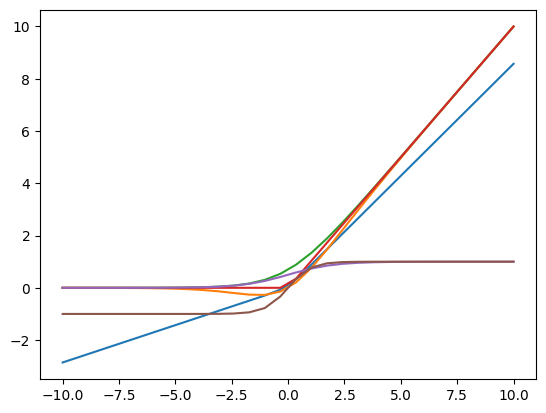

In [56]:
xfoo = jnp.linspace(-10, 10, 30)
plt.plot(xfoo, smooth_leaky(xfoo))
plt.plot(xfoo, nn.swish(xfoo))
plt.plot(xfoo, nn.softplus(xfoo))
plt.plot(xfoo, nn.relu(xfoo))
plt.plot(xfoo, nn.sigmoid(xfoo))
plt.plot(xfoo, nn.tanh(xfoo))

plt.show()

In [62]:
# initialise mpk model
model_key = jr.key(44)

embed_model = simpleCNN(
                filters=32,
                cls_compression=cls_compression,
                act_cnn=nn.relu,
                act_dense=nn.leaky_relu,
                n_extra=1,
                dtype=jnp.float32,
)

In [63]:
%xmode context

Exception reporting mode: Context


In [64]:
wembed = embed_model.init(model_key, {"kappa": jnp.ones((512,512,8)),
                                      "cls": jnp.ones((10,2,4,28))
                                     }
                                      )

#outs,bed = embed_model.apply(wembed, jnp.ones((512,512,8)))

#outs.shape

In [65]:
sum(x.size for x in jax.tree_util.tree_leaves(wembed))

70491

In [66]:
data = next(iter(train_dataset))

In [67]:
data['theta'].shape

(64, 3)

In [68]:
appl = lambda d: embed_model.apply(wembed, d)

outs = jax.vmap(appl)(data['y'])

outs.shape

(64, 4)

In [69]:
outs[4, :]

Array([ 0.5914678 ,  0.18422455,  0.8996529 , -1.675345  ], dtype=float32)

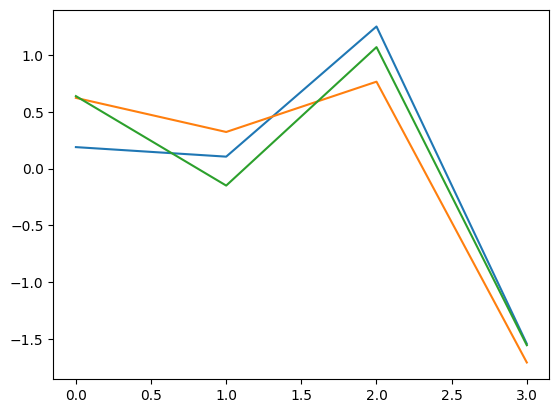

In [70]:

plt.plot((outs[0, :]))
plt.plot((outs[10, :]))
plt.plot((outs[44, :]))
plt.show()

In [71]:
jnp

<module 'jax.numpy' from '/home/makinen/venvs/epe/lib64/python3.11/site-packages/jax/numpy/__init__.py'>

# train network

TODO: make weights an attribute of the network so that we can cut training early

In [ ]:
from jax import numpy as jnp, random as jr
from sbijax import NPE
from sbijax.nn import make_maf, make_mdn
from tensorflow_probability.substrates.jax import distributions as tfd
import optax

#from network.train_utils import rotate_sim

# ---- DUMMY FUNCTIONS ----
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(low=jnp.array([-2, 0.1]), high=jnp.array([2, 10.0]))
    ), batch_ndims=0)
    return prior

def simulator_fn(seed, theta, n_d=50):
    #print("theta", theta["theta"].shape)
    theta = theta["theta"]
    p = tfd.Normal(jnp.zeros((theta.shape[0], n_d)), 1.0)
    noise =  p.sample(seed=seed) * jnp.sqrt(theta[..., 1, jnp.newaxis])
    y = theta[..., 0, jnp.newaxis] + noise
    return y

fns = prior_fn, simulator_fn # remove this dependency
# ---- DUMMY FUNCTIONS ----


mdn_hidden = (70,70)
n_components = 4 # 2 not so good


model = myNPE(fns, my_make_mdn(n_dimension=3,
                               n_components=n_components, embedding_net=embed_model,
                               hidden_sizes=mdn_hidden,
                               activation=jax.nn.relu))

# load parameters from last run
#w = load_obj("/home/makinen/repositories/des-hybrid/w_patchA_20_12_smoothleaky.pkl")



# TRAIN ONE PARAMETER AT A TIME
# define function that slices the parameters from the tf dataset
# (om, s8, w) = params

param_idx = 1

# let's see if we can improve on dark matter
train_dataset_single = get_tfdataset(train_files, BATCH_SIZE, scale_params=True, to_numpy=True, param_idx=param_idx)
test_dataset_single = get_tfdataset(test_files, BATCH_SIZE, scale_params=True, to_numpy=True, param_idx=param_idx)




# --- OPTIMISER STUFF
# Clip gradients at max value, and evt. apply weight decay
# transf = [optax.clip(float(config["gradient_clip"]))]
# transf.append(optax.add_decayed_weights(1e-4))
# optimizer = optax.chain(
#     *transf,
#     optax.adam(learning_rate=5e-5)
# )
epochs = 200

total_steps = 193
total_steps = (epochs * total_steps) + epochs
lr_schedule = optax.exponential_decay(init_value=2e-5, transition_steps=total_steps,
                                                      decay_rate=0.98, transition_begin=int(total_steps*0.25),
                                                      staircase=False)
optimizer = optax.adam(learning_rate=lr_schedule)
#optimizer = optax.adam(learning_rate=1e-5)
w, losses = model.fit(jr.PRNGKey(2), data=None, 
                      n_iter=epochs,
                      n_early_stopping_patience=10,  #20
                      train_dataset=train_dataset_single,
                      val_dataset=test_dataset_single,
                      noise_simulator=None, 
                      optimizer=optimizer,
                      outdir="./net-log-Om/",
                      #params=w
                    )

num files:  12352
retrieving parameter 1
num files:  3088
retrieving parameter 1


epoch 11 loss: -5.20780  val loss: -4.90036:   6%|▌         | 12/200 [1:00:05<15:06:11, 289.21s/it]2025-01-20 15:35:36.891688: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 537444608 bytes after encountering the first element of size 537444608 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-01-20 15:39:11.768676: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 537444608 bytes after encountering the first element of size 537444608 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
epoch 12 loss: -5.24668  val loss: -4.91840:   6%|▋         | 13/200 [1:05:12<15:17:55, 294.52s/it]2025-01-20 15:40:43.926825: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to a

In [75]:
postfix = "_patchA_19_01_vanilla_net_all_params_%d"%(param_idx)

In [40]:
#postfix = "_patchA_14_01_vanilla_net_all_params_layernorm2_extend2"

In [76]:
# save model weights
save_obj(w, "/home/makinen/repositories/des-hybrid/vanilla-comparison/w" + postfix)

In [77]:
np.save("/home/makinen/repositories/des-hybrid/vanilla-comparison/history" + postfix, losses)

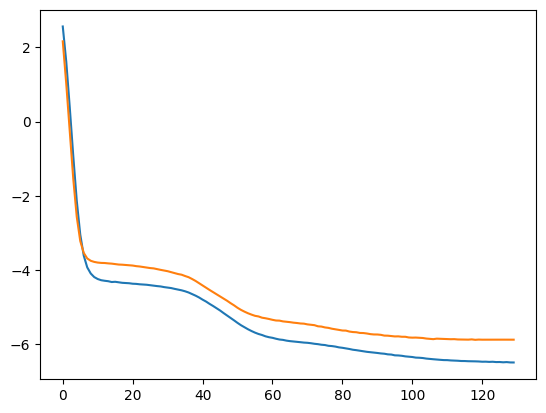

In [78]:
plt.plot(losses)
plt.show()

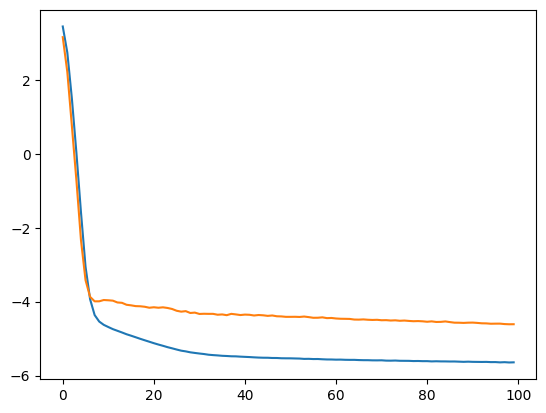

In [80]:
plt.plot(losses)
plt.show()

# load weights

In [154]:
from jax import numpy as jnp, random as jr
from sbijax import NPE
from sbijax.nn import make_maf, make_mdn
from tensorflow_probability.substrates.jax import distributions as tfd
import optax

#from network.train_utils import rotate_sim

# ---- DUMMY FUNCTIONS ----
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(low=jnp.array([-2, 0.1]), high=jnp.array([2, 10.0]))
    ), batch_ndims=0)
    return prior

def simulator_fn(seed, theta, n_d=50):
    #print("theta", theta["theta"].shape)
    theta = theta["theta"]
    p = tfd.Normal(jnp.zeros((theta.shape[0], n_d)), 1.0)
    noise =  p.sample(seed=seed) * jnp.sqrt(theta[..., 1, jnp.newaxis])
    y = theta[..., 0, jnp.newaxis] + noise
    return y

fns = prior_fn, simulator_fn # remove this dependency
# ---- DUMMY FUNCTIONS ----


mdn_hidden = (140,)
n_components = 4 # 2 not so good


model = myNPE(fns, my_make_mdn(n_dimension=3,
                               n_components=n_components, embedding_net=embed_model,
                               hidden_sizes=mdn_hidden,
                               activation=jax.nn.relu))


#w_trained = load_obj("/home/makinen/repositories/des-hybrid/w_patchA_04_12_swish.pkl")

In [241]:
w_trained = load_obj("/home/makinen/repositories/des-hybrid/wl-sbi/automate_run/best_params.pkl")

## run through ltu-ili for comprehensive posterior comparison

In [79]:
w_trained = w

In [80]:
# define a function to obtain summaries from the embedding module
#appfn = lambda d: model.model.apply(w, x=d, rng=jr.PRNGKey(400), method='embedding')

def apply_embedding(input_data, w=w_trained):
    return model.model.apply(w, x=input_data, rng=jr.PRNGKey(400), method='embedding')

In [81]:
# now apply to the lfi dataset as in Josh's code

summaries_LFI = []
params_Tru_LFI = []

for i in tqdm(range(lfi_dataset.num_batch_per_epoch)):

    data = next(iter(lfi_dataset))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_LFI.append(theta_true)
    summaries_LFI.append(summs_out)


summaries_test = []
params_Tru_test = []

for i in tqdm(range(test_dataset.num_batch_per_epoch)):

    data = next(iter(test_dataset))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_test.append(theta_true)
    summaries_test.append(summs_out)


summaries_sys = []
params_Tru_sys = []

for i in tqdm(range(sys_dataset.num_batch_per_epoch)):

    data = next(iter(sys_dataset))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_sys.append(theta_true)
    summaries_sys.append(summs_out)


# summaries_train = []
# params_Tru_train = []

# for i in tqdm(range(train_dataset.num_batch_per_epoch)):

#     data = next(iter(train_dataset))

#     X  = data['y']
#     theta_true = data['theta']
    
#     summs_out = apply_embedding(X)
    
#     params_Tru_train.append(theta_true)
#     summaries_train.append(summs_out)


100%|██████████| 48/48 [02:14<00:00,  2.79s/it]


In [29]:
summs_out.shape

(64, 6)

In [30]:
test_dataset.num_batch_per_epoch

48

In [45]:
len(summaries_LFI)

18432

In [43]:
postfix

'_patchA_14_01_vanilla_net_all_params'

In [82]:
summaries_LFI = np.concatenate(summaries_LFI, 0)
params_Tru_LFI = np.concatenate(params_Tru_LFI, 0)

summaries_test = np.concatenate(summaries_test, 0)
params_Tru_test = np.concatenate(params_Tru_test, 0)

summaries_sys = np.concatenate(summaries_sys, 0)
params_Tru_sys = np.concatenate(params_Tru_sys, 0)

# summaries_train = np.concatenate(summaries_train, 0)
# params_Tru_train = np.concatenate(params_Tru_train, 0)


In [89]:
postfix

'_patchA_19_01_vanilla_net_all_params_0'

In [90]:
np.savez("/home/makinen/repositories/des-hybrid/vanilla-comparison/summaries" + postfix,
         summaries_lfi=summaries_LFI,
         params_lfi=params_Tru_LFI,
         summaries_test=summaries_test,
         params_test=params_Tru_test,
         summaries_sys=summaries_sys,
         params_sys=params_Tru_sys,
         # summaries_train=summaries_train,
         # params_train=params_Tru_train
         )

In [49]:
params_Tru_test.shape

(3072, 3)

In [95]:
params_Tru_LFI.shape

(3072, 3)

In [91]:
summaries_LFI.shape

(3072, 4)

In [86]:
summaries_LFI[:, 2].std()

TypeError: list indices must be integers or slices, not tuple

In [29]:
summaries_LFI.shape

(3072, 6)

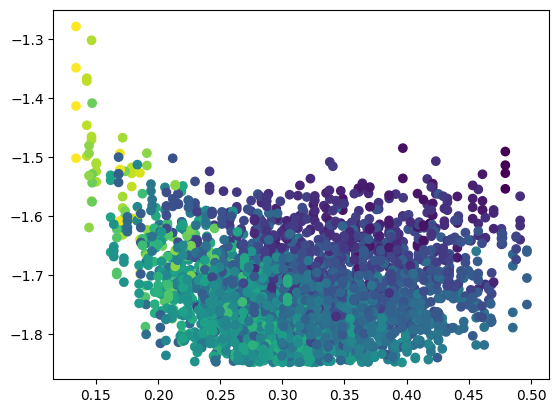

In [88]:
plt.scatter(params_Tru_LFI[:,0], summaries_LFI[:, -1], c=params_Tru_LFI[:, 1])
plt.show()
plt.close()

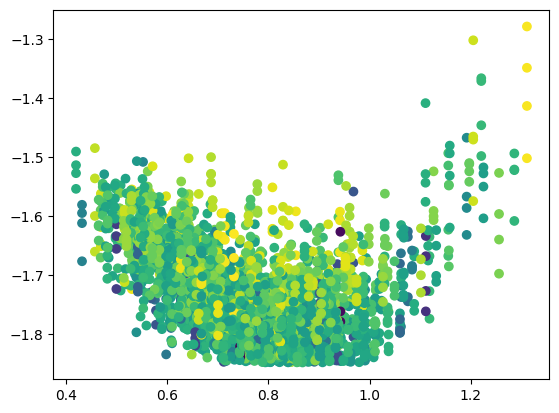

In [84]:
plt.scatter(params_Tru_LFI[:, 1], summaries_LFI[:, -1], c=params_Tru_LFI[:, 2])
plt.show()
plt.close()

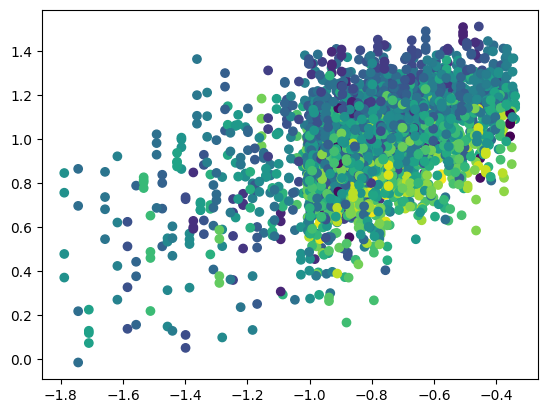

In [85]:
plt.scatter(params_Tru_LFI[:, 2], summaries_LFI[:, -2], c=params_Tru_LFI[:, 0])
plt.show()
plt.close()

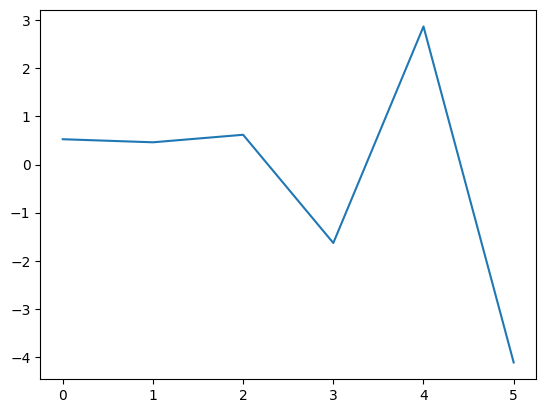

In [65]:
plt.plot(summaries_LFI[30, :])
plt.show()

In [59]:
summaries_LFI.shape

(3088, 565)

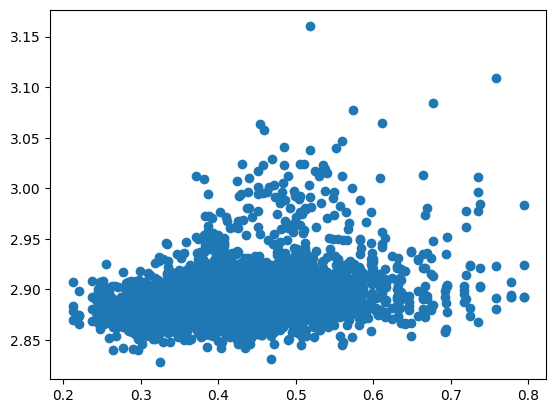

In [66]:
plt.scatter(params_Tru_test[:, 1], summaries_test[:, -2])
plt.show()
plt.close()

In [70]:
summaries_test.shape

(3024, 563)

In [65]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import torch

import numpy as np
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)


KeyboardInterrupt



In [ ]:
# make a dataloader for the predicted thetas and true thetas
#loader = NumpyLoader(x=np.concatenate([np.array(summs), summs_cls], axis=-1), theta=np.array(data['theta']))

In [ ]:
for d in range(3):
    print(params_Tru_LFI[:, d].min() - 0.001, params_Tru_LFI[:, d].max() + 0.001)

In [148]:
theta_fid = np.array([0.3, 0.8, -1.0])
np.argmin(np.sum((params_Tru_LFI - theta_fid)**2, 1))

617

In [63]:
summaries_LFI.shape

(3024, 83)

In [150]:
def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

In [151]:
get_S8(params_Tru_LFI)[:, 1].max(), get_S8(params_Tru_LFI)[:, 1].min()

(0.9987983, 0.50127)

In [239]:
from ili.embedding import FCN

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T


# CONVERT TO S8

params_Tru_LFI_S8 = get_S8(params_Tru_LFI)

loader = NumpyLoader(x=summaries_LFI,
                     theta=params_Tru_LFI_S8)

#n_hidden = [600, 300, 100, 4]
n_hidden = [30, 10, 4] # [100, 50, 25, 4]
embedding_network = FCN(n_hidden = n_hidden, act_fn = "LeakyReLU") # ReLU


# define a prior for the scaled thetas
#low=[0.1339, 0.418, -1.789]; high=[0.5, 1.312, -0.338]

low=[0.15, 0.5, -1.0]; high=[0.52, 1.0, -0.3333] # in S8

prior = ili.utils.Uniform(low=low, high=high, device=device)

# instantiate your neural networks to be used as an ensemble

nets = [
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=7),
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=12),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=10),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=110, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=110, num_transforms=10),

]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_network,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [240]:
posterior_ensemble, summaries = runner(loader=loader)

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 57 epochs.

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)


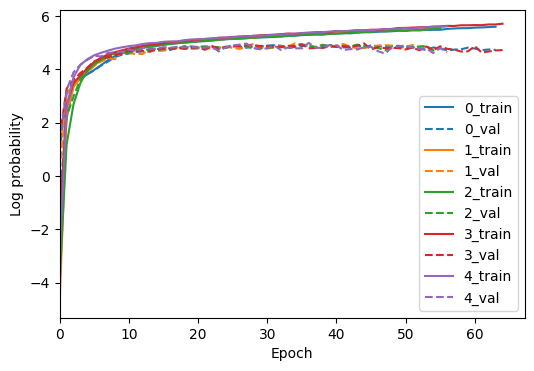

In [242]:
# FOR CNN + PK summaries

fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
plt.show()

In [216]:
params_Tru_LFI_S8.shape

(3024, 3)

In [226]:
# find somewhere close to fiducial

params_Tru_LFI_S8 = get_S8(params_Tru_LFI)

theta_fid = np.array([0.3, 0.8, -1.0])
target_index = np.argmin(np.sum(np.sqrt((params_Tru_LFI_S8 - theta_fid)**2), 1))

target_x = summaries_LFI[target_index]
target_theta = params_Tru_LFI_S8[target_index]

In [227]:
target_theta

array([ 0.279     ,  0.79077935, -1.        ], dtype=float32)

In [228]:
np.sum(np.sqrt((params_Tru_LFI_S8 - theta_fid)**2), 1)

array([0.35188586, 0.35188586, 0.35188586, ..., 0.72351851, 0.72351851,
       0.72351851])

Drawing 194 posterior samples:   0%|          | 0/194 [00:00<?, ?it/s]

Drawing 182 posterior samples:   0%|          | 0/182 [00:00<?, ?it/s]

Drawing 202 posterior samples:   0%|          | 0/202 [00:00<?, ?it/s]

Drawing 230 posterior samples:   0%|          | 0/230 [00:00<?, ?it/s]

Drawing 192 posterior samples:   0%|          | 0/192 [00:00<?, ?it/s]

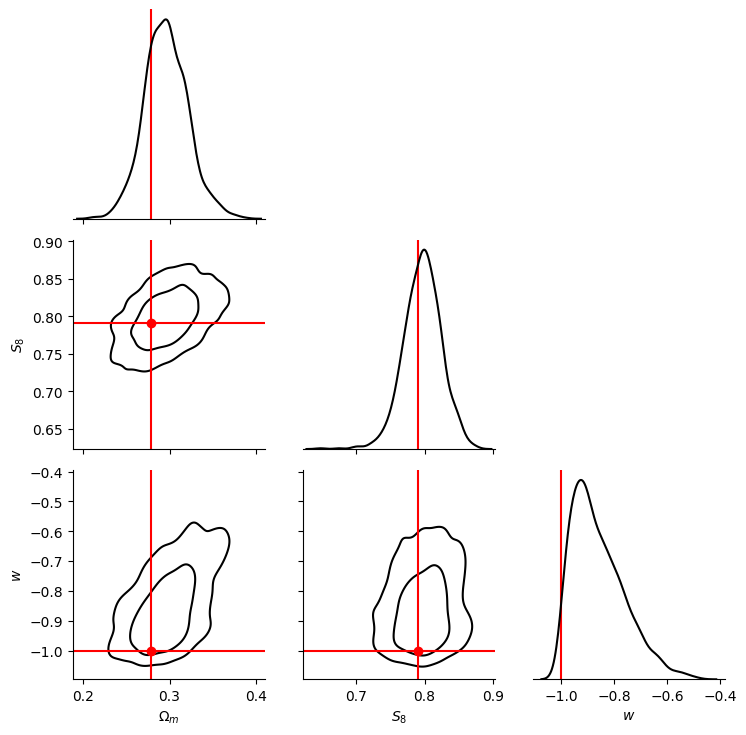

In [243]:

params = [r'$\Omega_m$', r'$S_8$', r'$w$']

metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=params
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = target_x, theta_fid=target_theta
)
plt.show()

In [197]:
summaries_LFI[..., :-3].shape

(3024, 80)

In [232]:
# do Cls-only

from ili.embedding import FCN

# DO JUST CLS NOW
loader_cls = NumpyLoader(x=summaries_LFI[..., :-3],
                     theta=params_Tru_LFI_S8)

n_hidden = [30, 10, 4] # [100, 50, 25, 4]
embedding_network = FCN(n_hidden = n_hidden, act_fn = "LeakyReLU") # ReLU


# define a prior for the scaled thetas
#low=[0.1339, 0.418, -1.789]; high=[0.5, 1.312, -0.338]

low=[0.15, 0.5, -1.0]; high=[0.52, 1.0, -0.3333] # in S8

prior = ili.utils.Uniform(low=low, high=high, device=device)

# instantiate your neural networks to be used as an ensemble

nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=7),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=12),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=10),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=110, num_transforms=8),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=110, num_transforms=10),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner_cls = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_network,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [233]:
posterior_ensemble_cls, summaries_cls = runner_cls(loader=loader_cls)

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 51 epochs..

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)


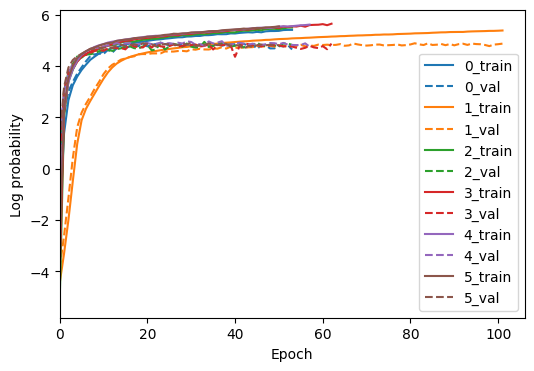

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries_cls):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
plt.show()

In [235]:
target_x.shape

(83,)

In [244]:
chains = posterior_ensemble.sample((100000,), x=torch.tensor(target_x).to(device))
chains_cls = posterior_ensemble_cls.sample((100000,), x=torch.tensor(target_x[:-3]).to(device))

Drawing 19128 posterior samples:   0%|          | 0/19128 [00:00<?, ?it/s]

Drawing 20238 posterior samples:   0%|          | 0/20238 [00:00<?, ?it/s]

Drawing 19700 posterior samples:   0%|          | 0/19700 [00:00<?, ?it/s]

Drawing 20021 posterior samples:   0%|          | 0/20021 [00:00<?, ?it/s]

Drawing 20913 posterior samples:   0%|          | 0/20913 [00:00<?, ?it/s]

Drawing 16037 posterior samples:   0%|          | 0/16037 [00:00<?, ?it/s]

Drawing 16224 posterior samples:   0%|          | 0/16224 [00:00<?, ?it/s]

Drawing 17210 posterior samples:   0%|          | 0/17210 [00:00<?, ?it/s]

Drawing 16223 posterior samples:   0%|          | 0/16223 [00:00<?, ?it/s]

Drawing 17505 posterior samples:   0%|          | 0/17505 [00:00<?, ?it/s]

Drawing 16801 posterior samples:   0%|          | 0/16801 [00:00<?, ?it/s]

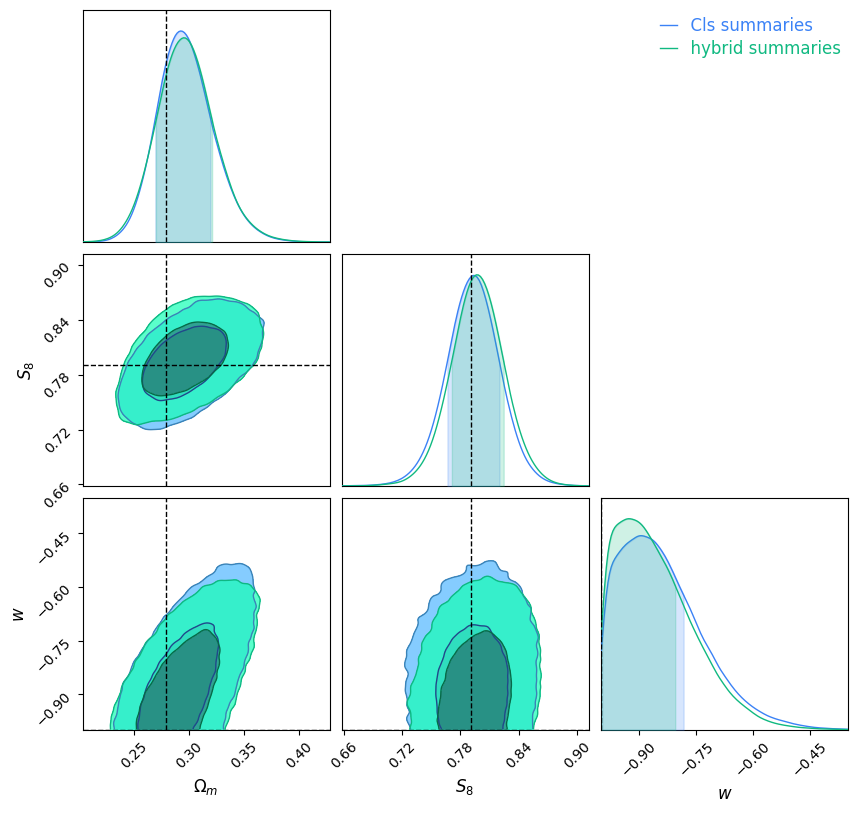

In [245]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

df = pd.DataFrame((chains.cpu().numpy()), columns=param_labels)
df_cls = pd.DataFrame((chains_cls.cpu().numpy()), columns=param_labels)


c = ChainConsumer()

_target_theta = (target_theta[np.newaxis, :]).squeeze()

c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: _target_theta[0], param_labels[1]: _target_theta[1], param_labels[2]:_target_theta[2]}))


fig = c.plotter.plot()
plt.show()

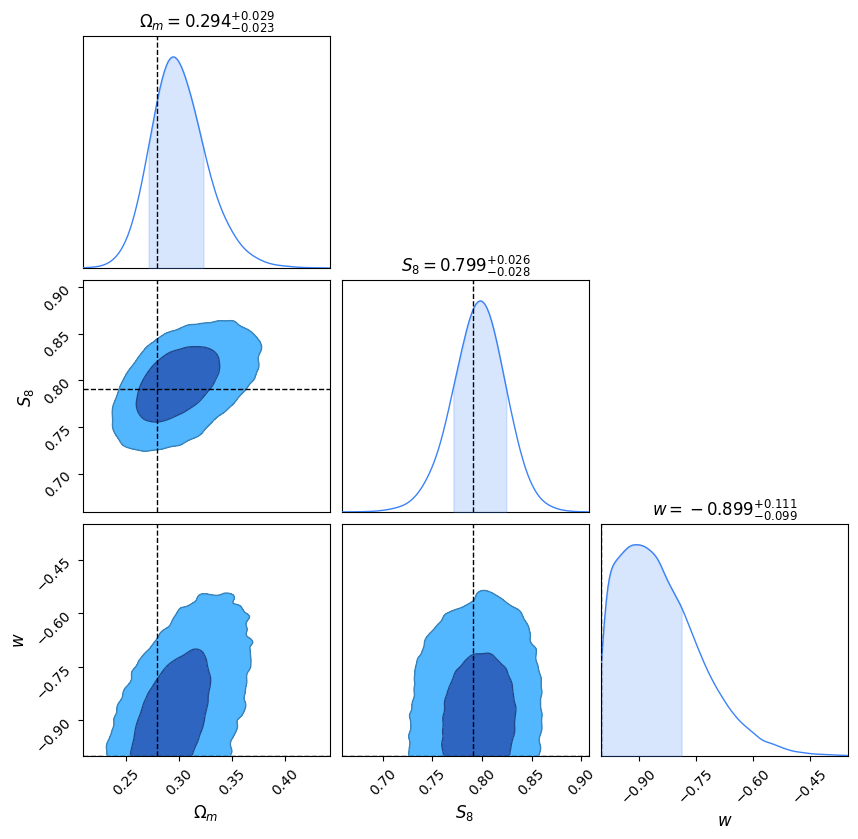

In [238]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

df = pd.DataFrame((chains.cpu().numpy()), columns=param_labels)
#df_cls = pd.DataFrame(get_S8(chains_cls.cpu().numpy()), columns=param_labels)


c = ChainConsumer()

_target_theta = (target_theta[np.newaxis, :]).squeeze()

#c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: _target_theta[0], param_labels[1]: _target_theta[1], param_labels[2]:_target_theta[2]}))


fig = c.plotter.plot()
plt.show()

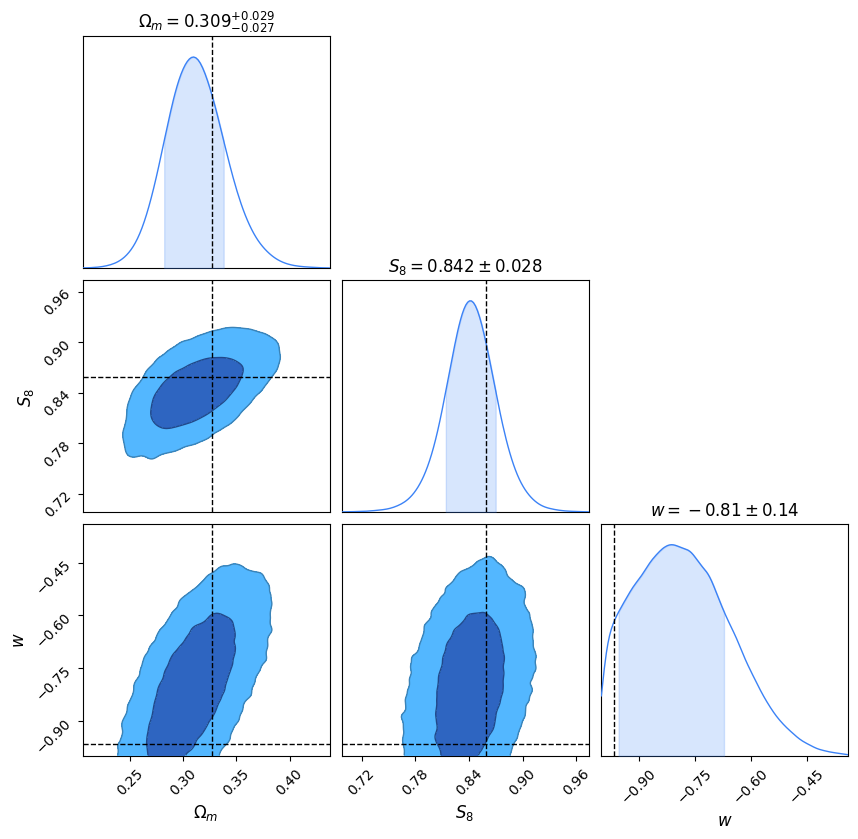

In [135]:
# LOOK AT CLS
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3), theta[:, 2]]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

#df = pd.DataFrame((chains.cpu().numpy()), columns=param_labels)
df_cls = pd.DataFrame((chains_cls.cpu().numpy()), columns=param_labels)


c = ChainConsumer()

_target_theta = (target_theta[np.newaxis, :]).squeeze()

c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
#c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: _target_theta[0], param_labels[1]: _target_theta[1], param_labels[2]:_target_theta[2]}))


fig = c.plotter.plot()
plt.show()

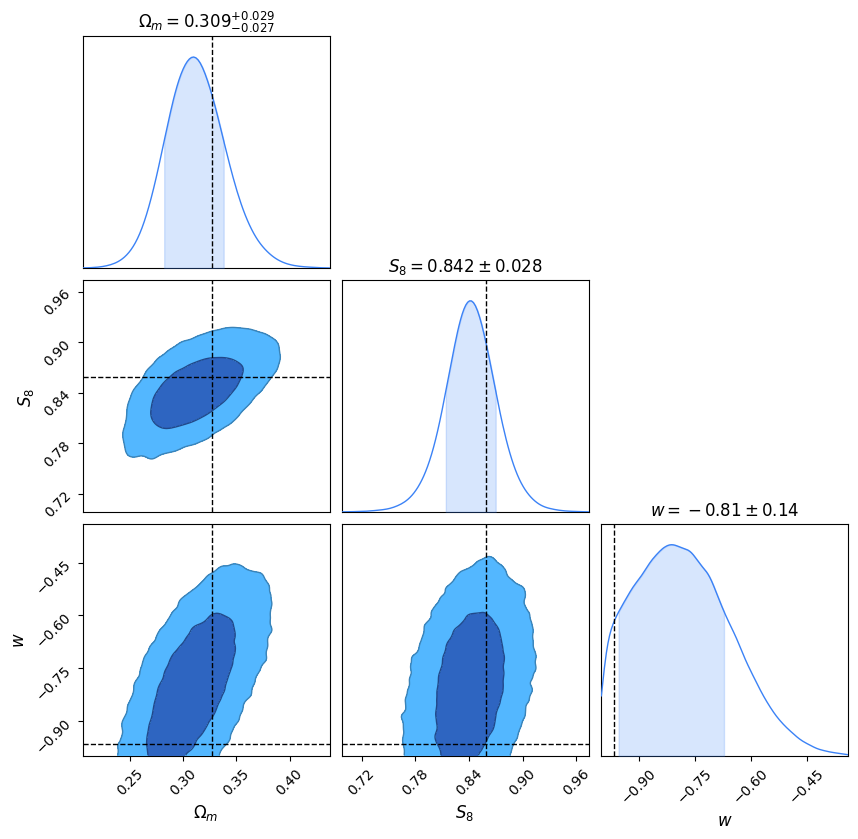

In [136]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T

def get_sigma8(theta):
    return np.array([theta[:, 0], theta[:, 1]/np.sqrt(theta[:, 0]/0.3)]).T

param_labels = [r'$\Omega_m$', r'$S_8$', r'$w$']
# samples_cls = get_sigma8(samples_cls.cpu().numpy()

df = pd.DataFrame(chains.cpu().numpy(), columns=param_labels)
df_cls = pd.DataFrame(chains_cls.cpu().numpy(), columns=param_labels)


c = ChainConsumer()
#c.add_chain(Chain(samples = df_cls, name="Cls summaries"))

c.add_chain(Chain(samples=df_cls, name="Cls summaries",))
#c.add_chain(Chain(samples=df, name="hybrid summaries",))
c.add_truth(Truth(location={param_labels[0]: target_theta[0], param_labels[1]: target_theta[1], param_labels[2]:target_theta[2]}))


fig = c.plotter.plot()
plt.show()

In [133]:
np.savez("/home/makinen/repositories/des-hybrid/results_patch_A_18_12",
         summaries_LFI=summaries_LFI,
         params_LFI=params_Tru_LFI_S8,
         summaries_test=summaries_test,
         params_test=get_S8(params_Tru_test),
         chains_hybrid=chains.cpu().numpy(),
         chains_cls=chains_cls.cpu().numpy()
        )

In [136]:
summaries_LFI

array([[ 0.4129078 ,  0.39613006,  0.4026416 , ..., -4.3125    ,
         5.875     , -1.9609375 ],
       [ 0.5837195 ,  0.52559936,  0.5304409 , ..., -3.6875    ,
         4.90625   , -1.6484375 ],
       [ 0.41967413,  0.39516655,  0.4027531 , ..., -4.4375    ,
         5.75      , -1.890625  ],
       ...,
       [ 0.41860172,  0.39765117,  0.40637466, ..., -4.21875   ,
         5.71875   , -1.8203125 ],
       [ 0.42122394,  0.40591896,  0.41452557, ..., -4.34375   ,
         5.8125    , -1.8984375 ],
       [ 0.41795707,  0.4000979 ,  0.40904242, ..., -4.1875    ,
         5.6875    , -1.8359375 ]], dtype=float32)

In [142]:
params_Tru_LFI_S8, summaries_LFI

(array([[ 0.26593444,  0.85225713, -0.8225309 ],
        [ 0.26593444,  0.85225713, -0.8225309 ],
        [ 0.26593444,  0.85225713, -0.8225309 ],
        ...,
        [ 0.3042592 ,  0.98120797, -0.46194866],
        [ 0.3042592 ,  0.98120797, -0.46194866],
        [ 0.3042592 ,  0.98120797, -0.46194866]], dtype=float32),
 array([[ 0.4129078 ,  0.39613006,  0.4026416 , ..., -4.3125    ,
          5.875     , -1.9609375 ],
        [ 0.5837195 ,  0.52559936,  0.5304409 , ..., -3.6875    ,
          4.90625   , -1.6484375 ],
        [ 0.41967413,  0.39516655,  0.4027531 , ..., -4.4375    ,
          5.75      , -1.890625  ],
        ...,
        [ 0.41860172,  0.39765117,  0.40637466, ..., -4.21875   ,
          5.71875   , -1.8203125 ],
        [ 0.42122394,  0.40591896,  0.41452557, ..., -4.34375   ,
          5.8125    , -1.8984375 ],
        [ 0.41795707,  0.4000979 ,  0.40904242, ..., -4.1875    ,
          5.6875    , -1.8359375 ]], dtype=float32))

In [146]:
# check coverage over TEST set

metric = PosteriorCoverage(
    num_samples=1000, sample_method='drect',
    labels=param_labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=(summaries_LFI), theta=(params_Tru_LFI_S8)
)
plt.show()

  0%|          | 0/3088 [00:00<?, ?it/s]


NotImplementedError: 

100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


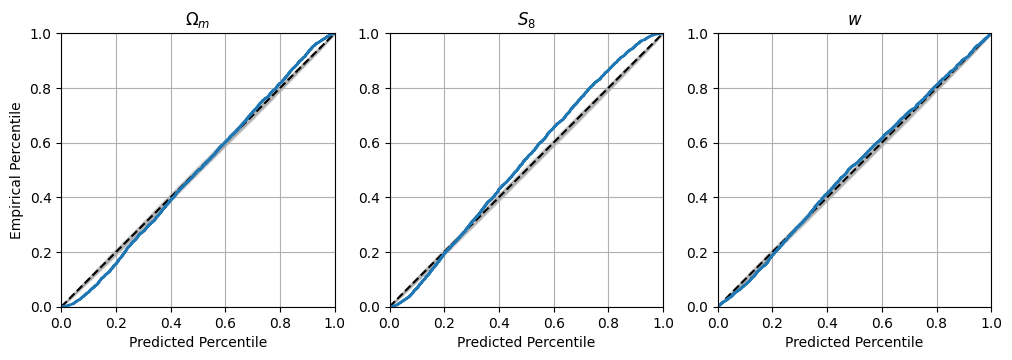

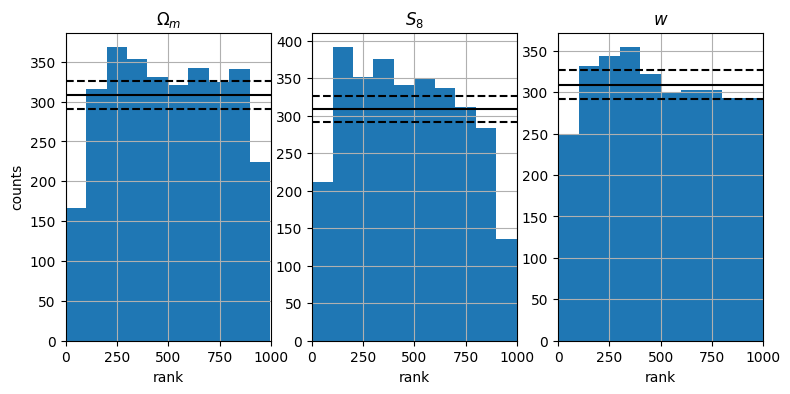

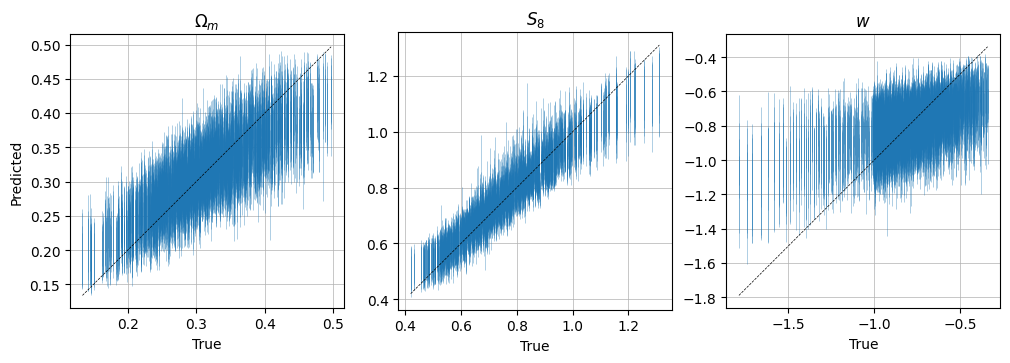

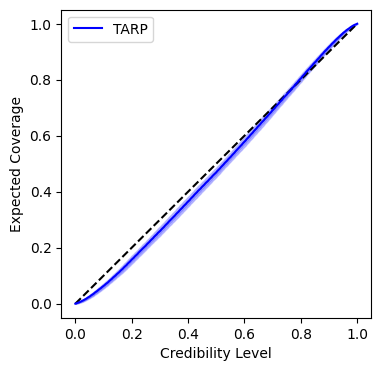

In [144]:
# check coverage

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=param_labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=summaries_test, theta=get_S8(params_Tru_test)
)
plt.show()

In [ ]:
# check parameter count

#sum(x.size for x in jax.tree_util.tree_leaves(wbest))